In [84]:
from dataclasses import dataclass
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random, vmap
import equinox as eqx
from typing import Callable, Union
from jaxtyping import Array
import sys
sys.path.append("..")
from networks._abstract_operator_net import AbstractOperatorNet, AbstractHparams
from utils.trainer import Trainer
from utils.model_utils import param_labels, conjugate_grads_transform
import optax
from functools import partial

@dataclass(kw_only=True, frozen=True)
class Hparams(AbstractHparams):
    # network parameters
    n_blocks: int # number of FNO blocks
    hidden_dim: int # dimension of the hidden layers
    modes_max: int # maximum number of modes to keep in the spectral convolutions
    period: float = 1.0 # period of the input function
    max_steps: int = 384 # step size for the time-stepping
    
class SpectralConv1d(eqx.Module):
    weights: jax.Array
    in_channels: int
    out_channels: int
    max_modes: int

    def __init__(self, in_channels, out_channels, max_modes, key):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.max_modes = max_modes

        init_std = jnp.sqrt(2.0 / (self.in_channels))
        self.weights = random.normal(key, (self.in_channels, self.out_channels, self.max_modes), dtype = jnp.complex64)*init_std


    def __call__(self,v):
        channels, spatial_points = v.shape

        # shape of v_hat is (in_channels, spatial_points//2+1)
        v_hat = jnp.fft.rfft(v) #rfft over the last axis
        
        # shape of v_hat_trunc is (in_channels, self.max_modes)
        v_hat_trunc = v_hat[:, :self.max_modes]
        
        # shape of out_hat is (out_channels, self.modes)
        out_hat = jnp.einsum("iM,ioM->oM", v_hat_trunc, self.weights) #i: in, o: out, M: modes

        # shape of out_hat is (out_channels, spatial_points//2+1)
        out_hat_padded = jnp.zeros((self.out_channels, v_hat.shape[-1]), dtype = v_hat.dtype)
        out_hat_padded = out_hat_padded.at[:, :self.max_modes].set(out_hat)

        out = jnp.fft.irfft(out_hat_padded, n=spatial_points)

        return out
    
class Bypass(eqx.Module):
    weights: Array

    def __init__(self, in_channels, out_channels, key):
        init_std = jnp.sqrt(2.0 / in_channels)
        self.weights = random.normal(key, (out_channels, in_channels))*init_std

    def __call__(self, v):
        return jnp.tensordot(self.weights, v, axes=1)
    
class FNOBlock1d(eqx.Module):
    spectral_conv: SpectralConv1d
    bypass: Bypass
    activation: Callable
    bias: Array
    
    def __init__(self, in_channels, out_channels, max_modes, activation, key = random.PRNGKey(0)):
        spectral_conv_key, bypass_key = jax.random.split(key)
        self.spectral_conv = SpectralConv1d(
            in_channels,
            out_channels,
            max_modes,
            spectral_conv_key,
        )
        
        self.bypass = Bypass(in_channels, out_channels, bypass_key)
        self.activation = activation
        self.bias = jnp.zeros((out_channels, 1))

    def __call__(self, v):
        # shape of v is (in_channels, spatial_points)
        return self.activation(self.spectral_conv(v) + self.bypass(v) + self.bias)

class FNOTimeStepping(AbstractOperatorNet):
    """Maps a function on a spatial domain at time t to the solution on the same spatial domain at time t.
    
    Input: (a(x,t), x, t)
        Shapes:
            a(x,t): (n, )
            x: (n, )
            t: (1, )
    Outputs: u(x,t)
        Shapes:
            u(x,t): (n, )
    """
    lifting: eqx.nn.Conv1d
    fno_blocks: FNOBlock1d
    projection: eqx.nn.Conv1d
    multiplier: float
    max_steps: int

    def __init__(self, hparams: Union[Hparams, dict]):
        if isinstance(hparams, dict):
            hparams = Hparams(**hparams)
        super().__init__(hparams)
        
        key = random.key(hparams.seed)
        keys = random.split(key, hparams.n_blocks + 2)
        
        self.lifting = eqx.nn.Conv1d(in_channels = 3, out_channels = hparams.hidden_dim, kernel_size = 1, key=keys[0])

        self.fno_blocks = eqx.filter_vmap(lambda key: FNOBlock1d(hparams.hidden_dim,hparams.hidden_dim,hparams.modes_max,jax.nn.gelu,key=key))(keys[1:-1])
        
        self.projection = eqx.nn.Conv1d(in_channels = hparams.hidden_dim, out_channels = 1, kernel_size = 1, key=keys[-1])
    
        self.multiplier = 2*jnp.pi/hparams.period
        
        self.max_steps = hparams.max_steps
    
    def stack_input(self, a, x):
        x_cos = jnp.cos(self.multiplier*x)
        x_sin = jnp.sin(self.multiplier*x)
        return jnp.stack([a, x_cos, x_sin])
    
    def __call__(self,a,x,t):
        t_max = jnp.linspace(0, 3, self.max_steps, endpoint=False)

        def step(v, _):
            # combine with spatial grid
            v_prev = v
            v = self.stack_input(v, x)
                        
            v = self.lifting(v)
            
            dynamic_fno_blocks, static_fno_blocks = eqx.partition(self.fno_blocks, eqx.is_array)
            
            def f(v, dynamic_fno_block):
                fno_block = eqx.combine(dynamic_fno_block, static_fno_blocks)
                return fno_block(v), None
            
            v, _ = jax.lax.scan(f, v, dynamic_fno_blocks)

            v = self.projection(v)[0]
            
            return v, v_prev
            
        _, out_max = jax.lax.scan(step, a, length = self.max_steps)
        
        out = jax.scipy.interpolate.RegularGridInterpolator((t_max,), out_max)(t)

        return out
    
    def predict_whole_grid(self, a, x, t):
        """Utility function for predicting the output over the whole grid."""
        return self(a, x, t)
    
    def get_self_adaptive(self):
        return self.self_adaptive

In [85]:
from dataclasses import dataclass
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random, vmap
import equinox as eqx
from typing import Callable, Union
from jaxtyping import Array
import sys
sys.path.append("..")
from networks._abstract_operator_net import AbstractOperatorNet, AbstractHparams
from utils.trainer import Trainer
from utils.model_utils import param_labels, conjugate_grads_transform
import optax
from functools import partial

from jax.scipy.interpolate import RegularGridInterpolator

@dataclass(kw_only=True, frozen=True)
class Hparams(AbstractHparams):
    # network parameters
    n_blocks: int # number of FNO blocks
    hidden_dim: int # dimension of the hidden layers
    modes_max: int # maximum number of modes to keep in the spectral convolutions
    period: float = 1.0 # period of the input function
    max_steps: int = 384 # step size for the time-stepping
    
class SpectralConv1d(eqx.Module):
    weights: jax.Array
    in_channels: int
    out_channels: int
    max_modes: int

    def __init__(self, in_channels, out_channels, max_modes, key):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.max_modes = max_modes

        init_std = jnp.sqrt(2.0 / (self.in_channels))
        self.weights = random.normal(key, (self.in_channels, self.out_channels, self.max_modes), dtype = jnp.complex64)*init_std


    def __call__(self,v):
        channels, spatial_points = v.shape

        # shape of v_hat is (in_channels, spatial_points//2+1)
        v_hat = jnp.fft.rfft(v) #rfft over the last axis
        
        # shape of v_hat_trunc is (in_channels, self.max_modes)
        v_hat_trunc = v_hat[:, :self.max_modes]
        
        # shape of out_hat is (out_channels, self.modes)
        out_hat = jnp.einsum("iM,ioM->oM", v_hat_trunc, self.weights) #i: in, o: out, M: modes

        # shape of out_hat is (out_channels, spatial_points//2+1)
        out_hat_padded = jnp.zeros((self.out_channels, v_hat.shape[-1]), dtype = v_hat.dtype)
        out_hat_padded = out_hat_padded.at[:, :self.max_modes].set(out_hat)

        out = jnp.fft.irfft(out_hat_padded, n=spatial_points)

        return out
    
class Bypass(eqx.Module):
    weights: Array

    def __init__(self, in_channels, out_channels, key):
        init_std = jnp.sqrt(2.0 / in_channels)
        self.weights = random.normal(key, (out_channels, in_channels))*init_std

    def __call__(self, v):
        return jnp.tensordot(self.weights, v, axes=1)
    
class FNOBlock1d(eqx.Module):
    spectral_conv: SpectralConv1d
    bypass: Bypass
    activation: Callable
    bias: Array
    
    def __init__(self, in_channels, out_channels, max_modes, activation, key = random.PRNGKey(0)):
        spectral_conv_key, bypass_key = jax.random.split(key)
        self.spectral_conv = SpectralConv1d(
            in_channels,
            out_channels,
            max_modes,
            spectral_conv_key,
        )
        
        self.bypass = Bypass(in_channels, out_channels, bypass_key)
        self.activation = activation
        self.bias = jnp.zeros((out_channels, 1))

    def __call__(self, v):
        # shape of v is (in_channels, spatial_points)
        return self.activation(self.spectral_conv(v) + self.bypass(v) + self.bias)

class FNOTimeStepping(AbstractOperatorNet):
    """Maps a function on a spatial domain at time t to the solution on the same spatial domain at time t.
    
    Input: (a(x,t), x, t)
        Shapes:
            a(x,t): (n, )
            x: (n, )
            t: (1, )
    Outputs: u(x,t)
        Shapes:
            u(x,t): (n, )
    """
    lifting: eqx.nn.Conv1d
    #fno_blocks: FNOBlock1d
    projection: eqx.nn.Conv1d
    multiplier: float
    max_steps: int
    t_max: Array = eqx.field(static=True)
    dynamic_fno_blocks: Array
    static_fno_blocks: Array

    def __init__(self, hparams: Union[Hparams, dict]):
        if isinstance(hparams, dict):
            hparams = Hparams(**hparams)
        super().__init__(hparams)
        
        key = random.key(hparams.seed)
        keys = random.split(key, hparams.n_blocks + 2)
        
        self.lifting = eqx.nn.Conv1d(in_channels = 3, out_channels = hparams.hidden_dim, kernel_size = 1, key=keys[0])

        fno_blocks = eqx.filter_vmap(lambda key: FNOBlock1d(hparams.hidden_dim,hparams.hidden_dim,hparams.modes_max,jax.nn.gelu,key=key))(keys[1:-1])
        
        self.projection = eqx.nn.Conv1d(in_channels = hparams.hidden_dim, out_channels = 1, kernel_size = 1, key=keys[-1])
    
        self.multiplier = 2*jnp.pi/hparams.period
        
        self.max_steps = hparams.max_steps
        
        self.t_max = jnp.linspace(0, 3, self.max_steps)
        
        self.dynamic_fno_blocks, self.static_fno_blocks = eqx.partition(fno_blocks, eqx.is_array)
    
    def stack_input(self, a, x):
        x_cos = jnp.cos(self.multiplier*x)
        x_sin = jnp.sin(self.multiplier*x)
        return jnp.stack([a, x_cos, x_sin])
    
    def __call__(self,a,x,t):
        #t_max = jnp.linspace(0, 3, self.max_steps)

        def step(v, _):
            # combine with spatial grid
            v_prev = v
            v = self.stack_input(v, x)
                        
            v = self.lifting(v)
            
            #dynamic_fno_blocks, static_fno_blocks = eqx.partition(self.fno_blocks, eqx.is_array)
            
            def f(v, dynamic_fno_block):
                fno_block = eqx.combine(dynamic_fno_block, self.static_fno_blocks)
                return fno_block(v), None
            
            v, _ = jax.lax.scan(f, v, self.dynamic_fno_blocks)

            v = self.projection(v)[0]
            
            return v, v_prev
            
        _, out_max = jax.lax.scan(step, a, length = self.max_steps)
        
        out = RegularGridInterpolator((self.t_max,), out_max)(t)

        return out
    
    def predict_whole_grid(self, a, x, t):
        """Utility function for predicting the output over the whole grid."""
        return self(a, x, t)
    
    def get_self_adaptive(self):
        return self.self_adaptive

In [86]:
problem = "kdv"
network = "fno_timestepping"
running_on = "local"
num_epochs = 5

if running_on == "local":
    data_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/data/"
    hparams_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/hyperparameters/"
    checkpoint_path = "C:/Users/eirik/orbax/"
elif running_on == "idun":
    data_path = "/cluster/work/eirikaf/data/"
    hparams_path = "/cluster/work/eirikaf/hyperparameters/"
    checkpoint_path = "/cluster/work/eirikaf/"
else:
    raise ValueError("Invalid running_on")

scaled_data = jnp.load(data_path + problem + "_scaled_data.npz")
a_train_s = jnp.array(scaled_data["a_train_s"])
u_train_s = jnp.array(scaled_data["u_train_s"])
a_val_s = jnp.array(scaled_data["a_val_s"])
u_val_s = jnp.array(scaled_data["u_val_s"])

x_train_s = jnp.array(scaled_data["x_train_s"])
t_train_s = jnp.array(scaled_data["t_train_s"])

In [87]:
hparams = Hparams(
    n_blocks=4,
    hidden_dim=64,
    modes_max=16,
    period=1.0,
    seed=42
)

fno_network = FNOTimeStepping(hparams)

C:\Users\eirik\AppData\Local\Temp\ipykernel_27212\4157224887.py:9: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  fno_network = FNOTimeStepping(hparams)


In [88]:
@jax.jit
def predict(a, x, t):
    return fno_network(a, x, t)

In [89]:
t = jnp.linspace(0, 3, 100)
x = jnp.linspace(-10, 10, 200)
a = jnp.ones(200)
_=predict(a, x, t)

In [90]:
%timeit jax.block_until_ready(predict(a, x, t))

1.02 s ± 66.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
import matplotlib.pyplot as plt

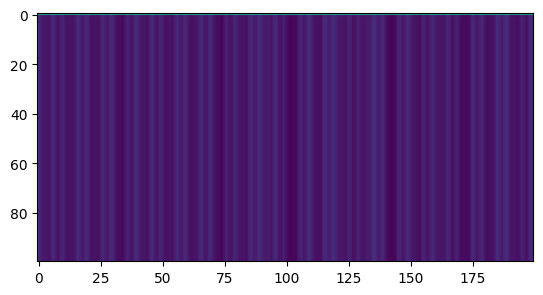

In [13]:
plt.imshow(pred)